#Traditional Model


In [ ]:
from google.colab import drive
import os
import tarfile
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import warnings
import time

warnings.filterwarnings('ignore')

# ✅ Mount Google Drive
drive.mount('/content/drive')


def extract_tarfile(tar_path, extract_to):
    if not os.path.exists(extract_to):  # Avoid re-extracting if already done
        os.makedirs(extract_to, exist_ok=True)
        with tarfile.open(tar_path, "r") as tar:
            tar.extractall(path=extract_to)

        # ✅ Move files up one level if they are inside a nested folder
        extracted_files = os.listdir(extract_to)
        if len(extracted_files) == 1 and os.path.isdir(os.path.join(extract_to, extracted_files[0])):
            nested_folder = os.path.join(extract_to, extracted_files[0])
            for filename in os.listdir(nested_folder):
                os.rename(os.path.join(nested_folder, filename), os.path.join(extract_to, filename))
            os.rmdir(nested_folder)  # Remove now-empty nested folder

        print(f"✅ Extracted {tar_path} to {extract_to}")
    else:
        print(f"⚠️ {extract_to} already exists. Skipping extraction.")

# ✅ Define dataset paths
train_tar_path = "/content/drive/MyDrive/train_set.tar"
val_tar_path = "/content/drive/MyDrive/val_set.tar"

train_extracted_path = "/content/train_set"
val_extracted_path = "/content/val_set"

# ✅ Extract and fix folder structure
extract_tarfile(train_tar_path, train_extracted_path)
extract_tarfile(val_tar_path, val_extracted_path)

# ✅ Define dataset directories
image_folders = {
    "TRAIN": f"{train_extracted_path}/images",
    "TRAIN_LABELS": f"{train_extracted_path}/labels",
    "VALID": f"{val_extracted_path}/images",
    "VALID_LABELS": f"{val_extracted_path}/labels"
}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extracted /content/drive/MyDrive/train_set.tar to /content/train_set
✅ Extracted /content/drive/MyDrive/val_set.tar to /content/val_set


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.AutoAugment(),  # ✅ Automatic data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

valid_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# ✅ Create Dataset & DataLoaders
image_folders = {
    "TRAIN": "/content/train_set/images",
    "TRAIN_LABELS": "/content/train_set/annotations",
    "VALID": "/content/val_set/images",
    "VALID_LABELS": "/content/val_set/annotations"
}



In [ ]:
import torchvision.models as models

# Load the model
model = models.resnet18(pretrained=True)

# Print full architecture
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import os

# Walk through everything in /content/train_set to find the actual folder structure
for root, dirs, files in os.walk("/content/train_set"):
    print(f"📁 Folder: {root}")
    if dirs:
        print(f"  📂 Subfolders: {dirs}")
    if files:
        print(f"  📄 Files: {files[:5]}{' ...' if len(files) > 5 else ''}")
    print("-" * 60)


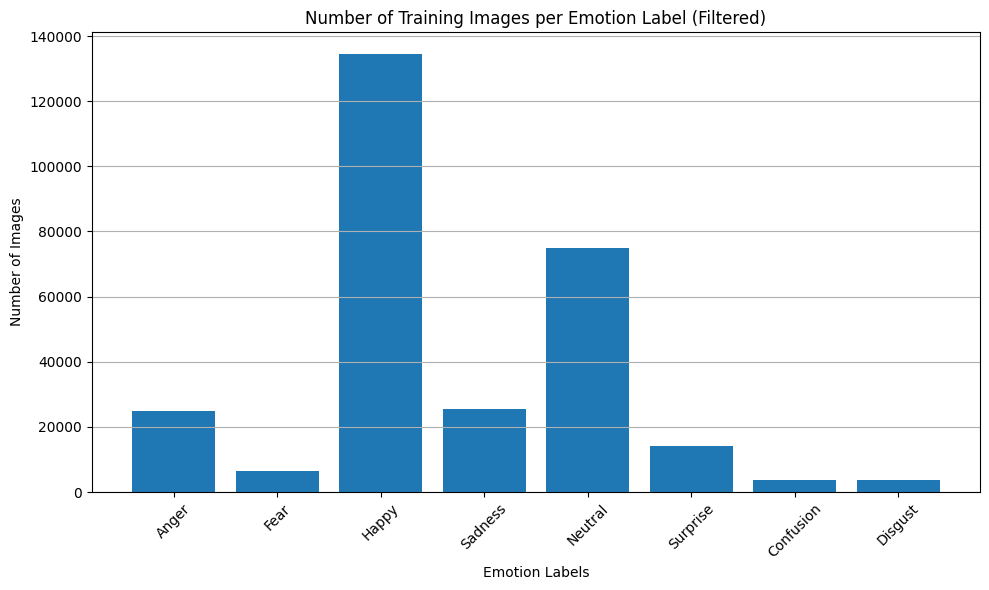

In [ ]:
# ✅ Now that we confirmed the structure, regenerate the label count chart

# Define correct paths
image_dir = "/content/train_set/images"
label_dir = "/content/train_set/annotations"

# Label remapping from original AffectNet format to desired 8-class format
label_remap = {
    0: 4,  # Neutral → 4
    1: 2,  # Happiness → 2
    2: 3,  # Sadness → 3
    3: 5,  # Surprise → 5
    4: 1,  # Fear → 1
    5: 7,  # Disgust → 7
    6: 0,  # Anger → 0
    7: 6,  # Contempt → Confusion (6)
    8: None,  # None → discard
    9: None,  # Uncertain → discard
    10: None  # No-Face → discard
}

# Label name mapping for final classes
label_names = {
    0: "Anger", 1: "Fear", 2: "Happy", 3: "Sadness",
    4: "Neutral", 5: "Surprise", 6: "Confusion", 7: "Disgust"
}

# Count remapped labels
from collections import Counter
label_counter = Counter()

for f in os.listdir(image_dir):
    if not f.endswith(('.jpg', '.png', '.jpeg')):
        continue
    label_path = os.path.join(label_dir, f.rsplit('.', 1)[0] + '_exp.npy')
    if os.path.exists(label_path):
        raw_label = int(np.load(label_path, allow_pickle=True))
        mapped_label = label_remap.get(raw_label)
        if mapped_label is not None:
            label_counter[mapped_label] += 1

# Prepare data for plotting
labels = [label_names[i] for i in range(8)]
counts = [label_counter[i] for i in range(8)]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel("Emotion Labels")
plt.ylabel("Number of Images")
plt.title("Number of Training Images per Emotion Label (Filtered)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import warnings
from collections import defaultdict
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Custom Dataset without any transformation
class AffectNetDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, max_per_class=20000):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = None  # No transformations used
        self.max_per_class = max_per_class

        self.label_remap = {
            0: 4, 1: 2, 2: 3, 3: 5, 4: 1,
            5: 7, 6: 0, 7: 6, 8: None, 9: None, 10: None
        }

        label_to_files = defaultdict(list)
        for f in os.listdir(image_dir):
            if not f.endswith(('.jpg', '.png', '.jpeg')):
                continue
            label_path = os.path.join(label_dir, f.rsplit('.', 1)[0] + '_exp.npy')
            if os.path.exists(label_path):
                label_raw = int(np.load(label_path, allow_pickle=True))
                label = self.label_remap.get(label_raw)
                if label is not None and len(label_to_files[label]) < self.max_per_class:
                    label_to_files[label].append(f)

        self.image_files = []
        self.labels = []
        for label, files in label_to_files.items():
            self.image_files.extend(files)
            self.labels.extend([label] * len(files))

        print(f"✅ Loaded {len(self.image_files)} total images with max {self.max_per_class} per class.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        label = self.labels[idx]

        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert("RGB")
        image = image.resize((224, 224))
        image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0

        return image, label

# ✅ Set Up Data Paths
image_folders = {
    "TRAIN": "/content/train_set/images",
    "TRAIN_LABELS": "/content/train_set/annotations",
    "VALID": "/content/val_set/images",
    "VALID_LABELS": "/content/val_set/annotations"
}

# ✅ Create Datasets & Loaders
train_dataset = AffectNetDataset(
    image_folders["TRAIN"],
    image_folders["TRAIN_LABELS"],
    max_per_class=20000
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

valid_dataset = AffectNetDataset(
    image_folders["VALID"],
    image_folders["VALID_LABELS"],
    max_per_class=1000
)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"\n✅ Loaded {len(train_dataset)} training images.")
print(f"✅ Loaded {len(valid_dataset)} validation images.")

# ✅ Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 8)
)
model.to(device)

# ✅ Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# ✅ Training Loop with F1 and History
num_epochs = 20
early_stopping_patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': []
}

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss_train, correct_train, total_train = 0.0, 0, 0
    all_train_preds, all_train_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

        running_loss_train += loss.item()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss_train / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')

    model.eval()
    running_loss_val, correct_val, total_val = 0.0, 0, 0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

            running_loss_val += loss.item()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_loss_val / len(valid_loader)
    val_accuracy = 100 * correct_val / total_val
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_accuracy)
    history['val_acc'].append(val_accuracy)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("\n✅ Model improved. Saved new best model.")
    else:
        epochs_without_improvement += 1
        print(f"\n⚠️ No improvement for {epochs_without_improvement} epochs.")

    if epochs_without_improvement >= early_stopping_patience:
        print("\n🚀 Early stopping triggered! Training stopped.")
        break

    scheduler.step(val_loss)

    print("=" * 75)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train  --> Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.2f}% | F1: {train_f1:.4f}")
    print(f"Val    --> Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.2f}% | F1: {val_f1:.4f}")
    print(f"Time per epoch: {time.time() - start_time:.2f} sec")
    print("=" * 75)

print("\n✅ Training complete! Best model saved as `best_model.pth`.")

# ✅ Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# ✅ (Optional) Plot F1 Score
plt.figure(figsize=(6, 5))
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Validation F1')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training & Validation F1 Score")
plt.legend()
plt.grid(True)
plt.show()


Class weights

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 108021 total images with max 20000 per class.
✅ Loaded 3999 total images with max 1000 per class.

✅ Loaded 108021 training images.
✅ Loaded 3999 validation images.
✅ Computed class weights: tensor([0.0522, 0.1638, 0.0522, 0.0522, 0.0522, 0.0741, 0.2785, 0.2747])

Class distribution in training set:
Class 0: 20000 samples
Class 1: 6378 samples
Class 2: 20000 samples
Class 3: 20000 samples
Class 4: 20000 samples
Class 5: 14090 samples
Class 6: 3750 samples
Class 7: 3803 samples


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]



✅ Model improved. Saved new best model.
Epoch 1/10
Train  --> Loss: 1.5851 | Accuracy: 41.64% | F1: 0.3776
Val    --> Loss: 1.4676 | Accuracy: 47.86% | F1: 0.4685
Time per epoch: 515.01 sec

✅ Model improved. Saved new best model.
Epoch 2/10
Train  --> Loss: 1.3546 | Accuracy: 49.67% | F1: 0.4561
Val    --> Loss: 1.3434 | Accuracy: 52.26% | F1: 0.5175
Time per epoch: 515.91 sec

✅ Model improved. Saved new best model.
Epoch 3/10
Train  --> Loss: 1.2834 | Accuracy: 52.10% | F1: 0.4803
Val    --> Loss: 1.2980 | Accuracy: 50.96% | F1: 0.5078
Time per epoch: 462.37 sec

✅ Model improved. Saved new best model.
Epoch 4/10
Train  --> Loss: 1.2359 | Accuracy: 53.94% | F1: 0.4982
Val    --> Loss: 1.2547 | Accuracy: 53.69% | F1: 0.5305
Time per epoch: 457.09 sec

✅ Model improved. Saved new best model.
Epoch 5/10
Train  --> Loss: 1.1932 | Accuracy: 55.25% | F1: 0.5116
Val    --> Loss: 1.2212 | Accuracy: 54.74% | F1: 0.5473
Time per epoch: 458.44 sec

⚠️ No improvement for 1 epochs.
Epoch 6/10
T

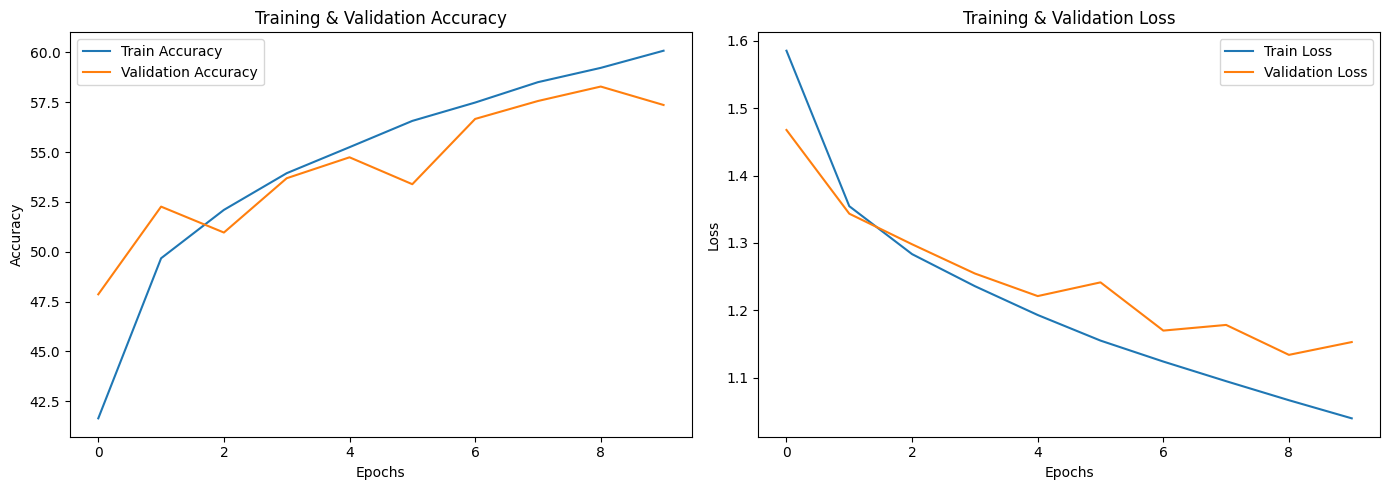

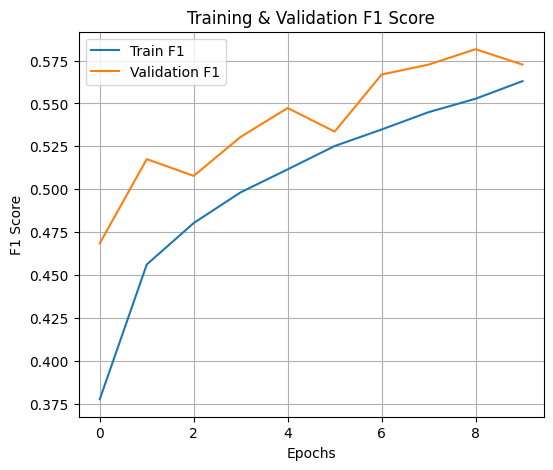

In [ ]:
from google.colab import drive
import os, time, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import defaultdict, Counter
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

warnings.filterwarnings('ignore')

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Custom Dataset without any transformation
class AffectNetDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, max_per_class=30000):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform  # ✅ Use passed transform
        self.max_per_class = max_per_class

        self.label_remap = {
            0: 4, 1: 2, 2: 3, 3: 5, 4: 1,
            5: 7, 6: 0, 7: 6, 8: None, 9: None, 10: None
        }

        label_to_files = defaultdict(list)
        for f in os.listdir(image_dir):
            if not f.endswith(('.jpg', '.png', '.jpeg')):
                continue
            label_path = os.path.join(label_dir, f.rsplit('.', 1)[0] + '_exp.npy')
            if os.path.exists(label_path):
                label_raw = int(np.load(label_path, allow_pickle=True))
                label = self.label_remap.get(label_raw)
                if label is not None and len(label_to_files[label]) < self.max_per_class:
                    label_to_files[label].append(f)

        self.image_files = []
        self.labels = []
        for label, files in label_to_files.items():
            self.image_files.extend(files)
            self.labels.extend([label] * len(files))

        print(f"✅ Loaded {len(self.image_files)} total images with max {self.max_per_class} per class.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        label = self.labels[idx]
        image_path = os.path.join(self.image_dir, image_filename)

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        else:
            image = image.resize((224, 224))
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0

        return image, label


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


# ✅ Set Up Data Paths
image_folders = {
    "TRAIN": "/content/train_set/images",
    "TRAIN_LABELS": "/content/train_set/annotations",
    "VALID": "/content/val_set/images",
    "VALID_LABELS": "/content/val_set/annotations"
}

# ✅ Create Datasets & Loaders
train_dataset = AffectNetDataset(
    image_folders["TRAIN"],
    image_folders["TRAIN_LABELS"],
    transform=train_transform,
    max_per_class=20000
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

valid_dataset = AffectNetDataset(
    image_folders["VALID"],
    image_folders["VALID_LABELS"],
    transform=valid_transform,
    max_per_class=1000
)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"\n✅ Loaded {len(train_dataset)} training images.")
print(f"✅ Loaded {len(valid_dataset)} validation images.")

# ✅ Compute Class Weights
label_counts = Counter(train_dataset.labels)
total_count = sum(label_counts.values())
num_classes = 8

class_weights = []
for i in range(num_classes):
    class_weights.append(total_count / (label_counts[i] + 1e-6))  # avoid div by 0

class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights / class_weights.sum()  # normalize

print("✅ Computed class weights:", class_weights)
print("\nClass distribution in training set:")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} samples")

# ✅ Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 8)
)
model.to(device)

# ✅ Loss with Class Weights, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# ✅ Training Loop with F1 and History
num_epochs = 10
early_stopping_patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': []
}

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss_train, correct_train, total_train = 0.0, 0, 0
    all_train_preds, all_train_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

        running_loss_train += loss.item()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss_train / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')

    model.eval()
    running_loss_val, correct_val, total_val = 0.0, 0, 0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

            running_loss_val += loss.item()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_loss_val / len(valid_loader)
    val_accuracy = 100 * correct_val / total_val
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_accuracy)
    history['val_acc'].append(val_accuracy)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("\n✅ Model improved. Saved new best model.")
    else:
        epochs_without_improvement += 1
        print(f"\n⚠️ No improvement for {epochs_without_improvement} epochs.")

    if epochs_without_improvement >= early_stopping_patience:
        print("\n🚀 Early stopping triggered! Training stopped.")
        break

    scheduler.step(val_loss)

    print("=" * 75)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train  --> Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.2f}% | F1: {train_f1:.4f}")
    print(f"Val    --> Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.2f}% | F1: {val_f1:.4f}")
    print(f"Time per epoch: {time.time() - start_time:.2f} sec")
    print("=" * 75)

print("\n✅ Training complete! Best model saved as `best_model.pth`.")

# ✅ Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# ✅ Plot F1 Score
plt.figure(figsize=(6, 5))
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Validation F1')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training & Validation F1 Score")
plt.legend()
plt.grid(True)
plt.show()



📊 Final Evaluation on Validation Set
Validation Loss    : 1.1341
Validation Accuracy: 58.29%

🧾 Classification Report
              precision    recall  f1-score   support

           0     0.5919    0.4700    0.5240       500
           1     0.6392    0.6200    0.6294       500
           2     0.7030    0.7620    0.7313       500
           3     0.5587    0.6000    0.5786       500
           4     0.4505    0.5000    0.4739       500
           5     0.5706    0.6220    0.5952       500
           6     0.5758    0.4870    0.5277       499
           7     0.5833    0.6020    0.5925       500

    accuracy                         0.5829      3999
   macro avg     0.5841    0.5829    0.5816      3999
weighted avg     0.5841    0.5829    0.5816      3999



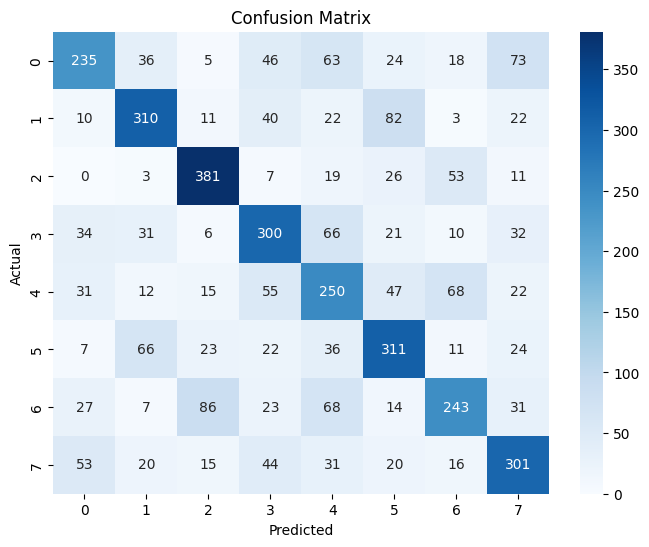

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load best model weights
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# ✅ Evaluation
all_preds = []
all_labels = []
val_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

final_accuracy = 100 * correct / total
val_loss /= len(valid_loader)

print("\n📊 Final Evaluation on Validation Set")
print(f"Validation Loss    : {val_loss:.4f}")
print(f"Validation Accuracy: {final_accuracy:.2f}%")

# ✅ Classification Report
print("\n🧾 Classification Report")
print(classification_report(all_labels, all_preds, digits=4))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# ✅ Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 8)  # 8 emotion classes
)
model.to(device)

# ✅ Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# ✅ Check for Checkpoint
start_epoch = 0
best_val_loss = float('inf')
checkpoint_path = "checkpoint.pth"

if os.path.exists(checkpoint_path):
    print("🔁 Loading checkpoint to resume training...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_val_loss = checkpoint['best_val_loss']
    start_epoch = checkpoint['epoch']
    print(f"✅ Resuming from epoch {start_epoch}")
else:
    print("🚀 No checkpoint found. Starting fresh.")

# ✅ Training Loop with Early Stopping
num_epochs = 100
early_stopping_patience = 3
epochs_without_improvement = 0

for epoch in range(start_epoch, num_epochs):
    start_time = time.time()
    model.train()
    running_loss_train, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss_train / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    model.eval()
    running_loss_val, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_loss_val / len(valid_loader)
    val_accuracy = 100 * correct_val / total_val

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        torch.save(model.state_dict(), "best_model.pth")
        print("\n✅ Model improved. Saved new best model and checkpoint.")
    else:
        epochs_without_improvement += 1
        print(f"\n⚠️ No improvement for {epochs_without_improvement} epochs.")

    if epochs_without_improvement >= early_stopping_patience:
        print("\n🚀 Early stopping triggered! Training stopped.")
        break

    scheduler.step(val_loss)

    print("=" * 75)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train  --> Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.2f}%")
    print(f"Val    --> Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.2f}%")
    print(f"Time per epoch: {time.time() - start_time:.2f} sec")
    print("=" * 75)

print("\n✅ Training complete! Best model saved as `best_model.pth`.")


Xception


In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# ✅ Paths & parameters
train_dir = "/content/train_set/images"
train_labels_dir = "/content/train_set/annotations"
val_dir = "/content/val_set/images"
val_labels_dir = "/content/val_set/annotations"
n_classes = 8
BATCH_SIZE = 32

# ✅ Label remapping dictionary
label_remap = {
    0: 4, 1: 2, 2: 3, 3: 5,
    4: 1, 5: 7, 6: 0, 7: 6,
    8: -1, 9: -1, 10: -1
}

def load_label(image_path, label_dir):
    image_name = tf.strings.split(image_path, os.sep)[-1]
    base_name = tf.strings.regex_replace(image_name, r'\.\w+$', '')
    label_path = tf.strings.join([label_dir, "/", base_name, "_exp.npy"])

    def load_and_cast(x):
        label = np.load(x, allow_pickle=True)
        if isinstance(label, (np.ndarray, list)):
            label = label.item()
        try:
            return np.int64(label)
        except Exception:
            return np.int64(-1)

    label = tf.numpy_function(load_and_cast, [label_path], tf.int64)
    label.set_shape(())
    return label

def remap_func(l):
    try:
        l_int = int(l)
    except Exception:
        l_int = int(l.decode('utf-8'))
    return np.int32(label_remap.get(l_int, -1))

def preprocess_image_label(image_path, label_dir):
    label = load_label(image_path, label_dir)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.xception.preprocess_input(image)
    remapped_label = tf.numpy_function(remap_func, [label], tf.int32)
    remapped_label.set_shape(())
    return image, remapped_label

def build_dataset(image_dir, label_dir, shuffle=True):
    files = tf.data.Dataset.list_files(image_dir + '/*.jpg', shuffle=shuffle)
    dataset = files.map(lambda path: preprocess_image_label(path, label_dir),
                        num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda img, label: label >= 0)
    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset = build_dataset(train_dir, train_labels_dir, shuffle=True)
val_dataset = build_dataset(val_dir, val_labels_dir, shuffle=False)

# ✅ Build the model
base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Conv2D(1024, kernel_size=3, padding="same", activation="relu")(base_model.output)
x = BatchNormalization()(x)
x = Conv2D(256, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(n_classes, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)

xception_model = Model(inputs=base_model.input, outputs=predictions)
xception_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Custom Training Loop with Logging
EPOCHS = 100
best_val_loss = float('inf')
early_stop_counter = 0
max_patience = 3

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    # Training
    train_loss, train_acc, steps = 0.0, 0.0, 0
    for x_batch, y_batch in train_dataset:
        loss, acc = xception_model.train_on_batch(x_batch, y_batch)
        train_loss += loss
        train_acc += acc
        steps += 1
    train_loss /= steps
    train_acc = (train_acc / steps) * 100

    # Validation
    val_loss, val_acc, steps = 0.0, 0.0, 0
    for x_batch, y_batch in val_dataset:
        loss, acc = xception_model.test_on_batch(x_batch, y_batch)
        val_loss += loss
        val_acc += acc
        steps += 1
    val_loss /= steps
    val_acc = (val_acc / steps) * 100

    epoch_time = time.time() - start_time
    improved = val_loss < best_val_loss

    if improved:
        best_val_loss = val_loss
        xception_model.save("best_xception_model.h5")
        status = "✅ Model improved. Saved new best model."
        early_stop_counter = 0
    else:
        status = "⚠️ No improvement."
        early_stop_counter += 1

    print(status)
    print("=" * 75)
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train  --> Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"Val    --> Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")
    print(f"Time per epoch: {epoch_time:.2f} sec")
    print("=" * 75)

    if early_stop_counter >= max_patience:
        print("⏹️ Early stopping triggered.")
        break

# ✅ Load best saved model
xception_model = tf.keras.models.load_model("best_xception_model.h5")
print("✅ Training complete and best model loaded.")


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


RESNET50

In [ ]:
import os
import numpy as np
from tqdm import tqdm

# AffectNet expression labels (0-7)
expression_labels = {
    0: 'neutral',
    1: 'happy',
    2: 'sad',
    3: 'surprise',
    4: 'fear',
    5: 'disgust',
    6: 'anger',
    7: 'contempt'
}

# Path to the root folder containing images and annotations
root_folder = '/content/train_set'

# Initialize counters and storage for expression counts
expression_counts = {label: 0 for label in range(8)}

# Collect all annotation files
annotation_folder = os.path.join(root_folder, 'annotations')
annotation_files = sorted([f for f in os.listdir(annotation_folder) if f.endswith('_exp.npy')])

# Output folder to store annotations (keeping all labels)
output_folder = os.path.join(root_folder, 'filtered_annotations')
os.makedirs(output_folder, exist_ok=True)

# Iterate through annotation files
for filename in tqdm(annotation_files, desc='Processing annotations'):
    file_path = os.path.join(annotation_folder, filename)
    label = int(np.load(file_path))

    # Only use labels 0 through 7
    if 0 <= label <= 7:
        # Count label
        expression_counts[label] += 1

        # Save the annotation to the output folder (no filtering beyond 0-7)
        np.save(os.path.join(output_folder, filename), label)

# Display final counts
print("\nExpression label distribution:")
for label, count in expression_counts.items():
    print(f"{expression_labels[label]} ({label}): {count}")

In [ ]:
from google.colab import drive
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import warnings
from collections import defaultdict
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Custom Dataset without any transformation
class AffectNetDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, max_per_class=30000):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = None  # No transformations used
        self.max_per_class = max_per_class

        self.label_remap = {
            0: 4, 1: 2, 2: 3, 3: 5, 4: 1,
            5: 7, 6: 0, 7: 6, 8: None, 9: None, 10: None
        }

        label_to_files = defaultdict(list)
        for f in os.listdir(image_dir):
            if not f.endswith(('.jpg', '.png', '.jpeg')):
                continue
            label_path = os.path.join(label_dir, f.rsplit('.', 1)[0] + '_exp.npy')
            if os.path.exists(label_path):
                label_raw = int(np.load(label_path, allow_pickle=True))
                label = self.label_remap.get(label_raw)
                if label is not None and len(label_to_files[label]) < self.max_per_class:
                    label_to_files[label].append(f)

        self.image_files = []
        self.labels = []
        for label, files in label_to_files.items():
            self.image_files.extend(files)
            self.labels.extend([label] * len(files))

        print(f"✅ Loaded {len(self.image_files)} total images with max {self.max_per_class} per class.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        label = self.labels[idx]

        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert("RGB")
        image = image.resize((224, 224))
        image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0

        return image, label

# ✅ Set Up Data Paths
image_folders = {
    "TRAIN": "/content/train_set/images",
    "TRAIN_LABELS": "/content/train_set/filtered_annotations",
    "VALID": "/content/val_set/images",
    "VALID_LABELS": "/content/val_set/filtered_annotations"
}

# ✅ Create Datasets & Loaders
train_dataset = AffectNetDataset(
    image_folders["TRAIN"],
    image_folders["TRAIN_LABELS"],
    max_per_class=20000
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

valid_dataset = AffectNetDataset(
    image_folders["VALID"],
    image_folders["VALID_LABELS"],
    max_per_class=1000
)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"\n✅ Loaded {len(train_dataset)} training images.")
print(f"✅ Loaded {len(valid_dataset)} validation images.")

# ✅ Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 8)
)
model.to(device)

# ✅ Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# ✅ Training Loop with F1 and History
num_epochs = 20
early_stopping_patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': []
}

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss_train, correct_train, total_train = 0.0, 0, 0
    all_train_preds, all_train_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

        running_loss_train += loss.item()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss_train / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')

    model.eval()
    running_loss_val, correct_val, total_val = 0.0, 0, 0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

            running_loss_val += loss.item()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_loss_val / len(valid_loader)
    val_accuracy = 100 * correct_val / total_val
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_accuracy)
    history['val_acc'].append(val_accuracy)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("\n✅ Model improved. Saved new best model.")
    else:
        epochs_without_improvement += 1
        print(f"\n⚠️ No improvement for {epochs_without_improvement} epochs.")

    if epochs_without_improvement >= early_stopping_patience:
        print("\n🚀 Early stopping triggered! Training stopped.")
        break

    scheduler.step(val_loss)

    print("=" * 75)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train  --> Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.2f}% | F1: {train_f1:.4f}")
    print(f"Val    --> Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.2f}% | F1: {val_f1:.4f}")
    print(f"Time per epoch: {time.time() - start_time:.2f} sec")
    print("=" * 75)

print("\n✅ Training complete! Best model saved as `best_model.pth`.")

# ✅ Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# ✅ Plot F1 Score
plt.figure(figsize=(6, 5))
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Validation F1')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training & Validation F1 Score")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# 🔁 Load model
model = load_model("best_resnet50_model.h5")

# 🧪 Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_dataset)
print("\n📊 Final Evaluation on Validation Set")
print(f"Validation Loss    : {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.1890 - loss: 2.8757

📊 Final Evaluation on Validation Set
Validation Loss    : 2.8756
Validation Accuracy: 18.65%


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

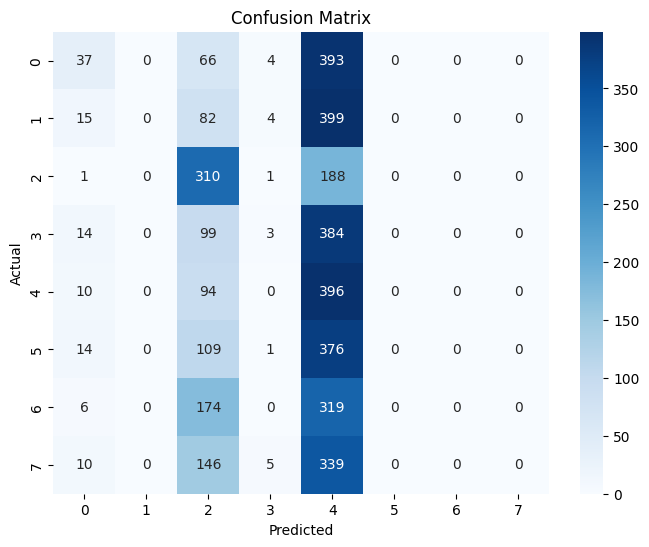

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 🧠 Get ground truth and predictions
y_true = []
y_pred = []

for x_batch, y_batch in val_dataset:
    preds = model.predict(x_batch)
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# 🧾 Classification report
print("\n🧾 Classification Report")
print(classification_report(y_true, y_pred, digits=4))

# 📉 Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# ✅ Paths & parameters
train_dir = "/content/train_set/images"
train_labels_dir = "/content/train_set/annotations"
val_dir = "/content/val_set/images"
val_labels_dir = "/content/val_set/annotations"
n_classes = 8
BATCH_SIZE = 32
IMAGE_SIZE = 224

# ✅ Label remapping
label_remap = {
    0: 4, 1: 2, 2: 3, 3: 5,
    4: 1, 5: 7, 6: 0, 7: 6,
    8: -1, 9: -1, 10: -1
}

# ✅ Load label from .npy file
def load_label(image_path, label_dir):
    image_name = tf.strings.split(image_path, os.sep)[-1]
    base_name = tf.strings.regex_replace(image_name, r'\.\w+$', '')
    label_path = tf.strings.join([label_dir, "/", base_name, "_exp.npy"])

    def load_and_cast(x):
        label = np.load(x, allow_pickle=True)
        if isinstance(label, (np.ndarray, list)):
            label = label.item()
        try:
            return np.int64(label)
        except Exception:
            return np.int64(-1)

    label = tf.numpy_function(load_and_cast, [label_path], tf.int64)
    label.set_shape(())
    return label

def remap_func(l):
    try:
        l_int = int(l)
    except Exception:
        l_int = int(l.decode('utf-8'))
    return np.int32(label_remap.get(l_int, -1))

def preprocess_image_label(image_path, label_dir):
    label = load_label(image_path, label_dir)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    remapped_label = tf.numpy_function(remap_func, [label], tf.int32)
    remapped_label.set_shape(())
    return image, remapped_label

def build_dataset(image_dir, label_dir, shuffle=True, limit=None):
    files = tf.data.Dataset.list_files(image_dir + '/*.jpg', shuffle=shuffle)
    if limit:
        files = files.take(limit)
    dataset = files.map(lambda path: preprocess_image_label(path, label_dir),
                        num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda img, label: label >= 0)
    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ✅ Load datasets (train limited to 2000)
train_dataset = build_dataset(train_dir, train_labels_dir, shuffle=True, limit=2000)
val_dataset = build_dataset(val_dir, val_labels_dir, shuffle=False)

# ✅ Load ResNet50 base model (no top, with weights)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze feature extractor

# ✅ Build model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(n_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ✅ Custom training loop with logging
EPOCHS = 100
best_val_loss = float('inf')
early_stop_counter = 0
max_patience = 3

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    # 🔁 Training loop
    train_loss, train_acc, steps = 0.0, 0.0, 0
    for x_batch, y_batch in train_dataset:
        loss, acc = model.train_on_batch(x_batch, y_batch)
        train_loss += loss
        train_acc += acc
        steps += 1
    train_loss /= steps
    train_acc = (train_acc / steps) * 100

    # 🔍 Validation loop
    val_loss, val_acc, steps = 0.0, 0.0, 0
    for x_batch, y_batch in val_dataset:
        loss, acc = model.test_on_batch(x_batch, y_batch)
        val_loss += loss
        val_acc += acc
        steps += 1
    val_loss /= steps
    val_acc = (val_acc / steps) * 100

    epoch_time = time.time() - start_time
    improved = val_loss < best_val_loss

    if improved:
        best_val_loss = val_loss
        model.save("best_resnet50_model.h5")
        status = "✅ Model improved. Saved new best model."
        early_stop_counter = 0
    else:
        status = "⚠️ No improvement."
        early_stop_counter += 1

    print(status)
    print("=" * 75)
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train  --> Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"Val    --> Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")
    print(f"Time per epoch: {epoch_time:.2f} sec")
    print("=" * 75)

    if early_stop_counter >= max_patience:
        print("⏹️ Early stopping triggered.")
        break

# ✅ Load best saved model
model = tf.keras.models.load_model("best_resnet50_model.h5")
print("✅ Training complete and best model loaded.")

✅ Model improved. Saved new best model.
Epoch 1/100
Train  --> Loss: 1.7706 | Accuracy: 44.83%
Val    --> Loss: 2.0599 | Accuracy: 35.51%
Time per epoch: 61.02 sec
⚠️ No improvement.
Epoch 2/100
Train  --> Loss: 2.1561 | Accuracy: 32.30%
Val    --> Loss: 2.1901 | Accuracy: 32.01%
Time per epoch: 23.09 sec
⚠️ No improvement.
Epoch 3/100
Train  --> Loss: 2.2154 | Accuracy: 31.56%
Val    --> Loss: 2.1976 | Accuracy: 31.82%
Time per epoch: 23.04 sec
⚠️ No improvement.
Epoch 4/100
Train  --> Loss: 2.1819 | Accuracy: 32.17%
Val    --> Loss: 2.1727 | Accuracy: 32.41%
Time per epoch: 22.23 sec
⏹️ Early stopping triggered.


✅ Training complete and best model loaded.


#RESEMOTE

In [ ]:
from google.colab import drive
import os
import tarfile
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import warnings
import time

warnings.filterwarnings('ignore')

# ✅ Mount Google Drive
drive.mount('/content/drive')


def extract_tarfile(tar_path, extract_to):
    if not os.path.exists(extract_to):  # Avoid re-extracting if already done
        os.makedirs(extract_to, exist_ok=True)
        with tarfile.open(tar_path, "r") as tar:
            tar.extractall(path=extract_to)

        # ✅ Move files up one level if they are inside a nested folder
        extracted_files = os.listdir(extract_to)
        if len(extracted_files) == 1 and os.path.isdir(os.path.join(extract_to, extracted_files[0])):
            nested_folder = os.path.join(extract_to, extracted_files[0])
            for filename in os.listdir(nested_folder):
                os.rename(os.path.join(nested_folder, filename), os.path.join(extract_to, filename))
            os.rmdir(nested_folder)  # Remove now-empty nested folder

        print(f"✅ Extracted {tar_path} to {extract_to}")
    else:
        print(f"⚠️ {extract_to} already exists. Skipping extraction.")

# ✅ Define dataset paths
train_tar_path = "/content/drive/MyDrive/train_set.tar"
val_tar_path = "/content/drive/MyDrive/val_set.tar"

train_extracted_path = "/content/train_set"
val_extracted_path = "/content/val_set"

# ✅ Extract and fix folder structure
extract_tarfile(train_tar_path, train_extracted_path)
extract_tarfile(val_tar_path, val_extracted_path)

# ✅ Define dataset directories
image_folders = {
    "TRAIN": f"{train_extracted_path}/images",
    "TRAIN_LABELS": f"{train_extracted_path}/labels",
    "VALID": f"{val_extracted_path}/images",
    "VALID_LABELS": f"{val_extracted_path}/labels"
}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extracted /content/drive/MyDrive/train_set.tar to /content/train_set
✅ Extracted /content/drive/MyDrive/val_set.tar to /content/val_set


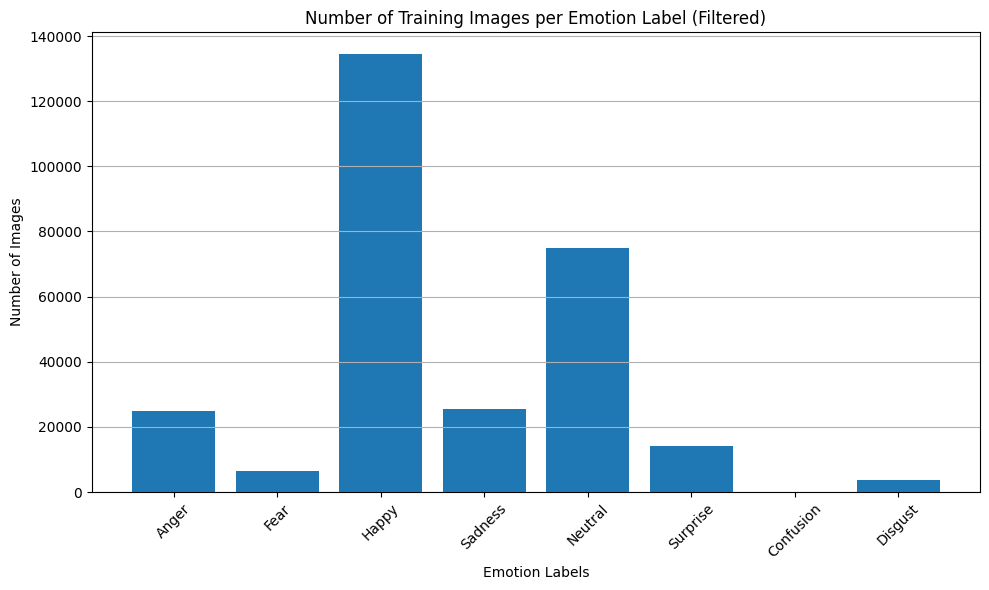

In [ ]:
    # ✅ Now that we confirmed the structure, regenerate the label count chart

    # Define correct paths
    image_dir = "/content/train_set/images"
    label_dir = "/content/train_set/annotations"

    # Label remapping from original AffectNet format to desired 8-class format
    label_remap = {
        0: 4,  # Neutral → 4
        1: 2,  # Happiness → 2
        2: 3,  # Sadness → 3
        3: 5,  # Surprise → 5
        4: 1,  # Fear → 1a
        5: 7,  # Disgust → 7
        6: 0,  # Anger → 0
        7: None,  # Contempt → Confusion (6)
        8: None,  # None → discard
        9: None,  # Uncertain → discard
        10: None  # No-Face → discard
    }

    # Label name mapping for final classes
    label_names = {
        0: "Anger", 1: "Fear", 2: "Happy", 3: "Sadness",
        4: "Neutral", 5: "Surprise", 6: "Confusion", 7: "Disgust"
    }

    # Count remapped labels
    from collections import Counter
    label_counter = Counter()

    for f in os.listdir(image_dir):
        if not f.endswith(('.jpg', '.png', '.jpeg')):
            continue
        label_path = os.path.join(label_dir, f.rsplit('.', 1)[0] + '_exp.npy')
        if os.path.exists(label_path):
            raw_label = int(np.load(label_path, allow_pickle=True))
            mapped_label = label_remap.get(raw_label)
            if mapped_label is not None:
                label_counter[mapped_label] += 1

    # Prepare data for plotting
    labels = [label_names[i] for i in range(8)]
    counts = [label_counter[i] for i in range(8)]

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    plt.xlabel("Emotion Labels")
    plt.ylabel("Number of Images")
    plt.title("Number of Training Images per Emotion Label (Filtered)")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [ ]:
from google.colab import drive
import os, time, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import defaultdict, Counter
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

warnings.filterwarnings('ignore')

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Dataset Class with Transform Support
class AffectNetDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, max_per_class=10000):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.max_per_class = max_per_class

        self.label_remap = {
            0: 4, 1: 2, 2: 3, 3: 5, 4: 1,
            5: 7, 6: 0, 7: 6, 8: None, 9: None, 10: None
        }

        label_to_files = defaultdict(list)
        for f in os.listdir(image_dir):
            if not f.endswith(('.jpg', '.png', '.jpeg')):
                continue
            label_path = os.path.join(label_dir, f.rsplit('.', 1)[0] + '_exp.npy')
            if os.path.exists(label_path):
                label_raw = int(np.load(label_path, allow_pickle=True))
                label = self.label_remap.get(label_raw)
                if label is not None and len(label_to_files[label]) < self.max_per_class:
                    label_to_files[label].append(f)

        self.image_files = []
        self.labels = []
        for label, files in label_to_files.items():
            self.image_files.extend(files)
            self.labels.extend([label] * len(files))

        print(f"✅ Loaded {len(self.image_files)} total images with max {self.max_per_class} per class.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        label = self.labels[idx]
        image_path = os.path.join(self.image_dir, image_filename)

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        else:
            image = image.resize((224, 224))
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0

        return image, label

# ✅ Transforms
# ✅ Transforms: Augmentations that simulate your PIL-based ones
train_transform = transforms.Compose([
    transforms.RandomRotation(30),  # Random rotation up to ±30°
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop and resize to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Add color variation
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ✅ Paths
image_folders = {
    "TRAIN": "/content/train_set/images",
    "TRAIN_LABELS": "/content/train_set/annotations",
    "VALID": "/content/val_set/images",
    "VALID_LABELS": "/content/val_set/annotations"
}

# ✅ Datasets and Loaders
train_dataset = AffectNetDataset(
    image_folders["TRAIN"], image_folders["TRAIN_LABELS"],
    transform=train_transform, max_per_class=10000
)
valid_dataset = AffectNetDataset(
    image_folders["VALID"], image_folders["VALID_LABELS"],
    transform=valid_transform, max_per_class=1000
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"\n✅ Loaded {len(train_dataset)} training images.")
print(f"✅ Loaded {len(valid_dataset)} validation images.")

# ✅ Class Weights
label_counts = Counter(train_dataset.labels)
total_count = sum(label_counts.values())
num_classes = 8
class_weights = torch.tensor([
    total_count / (label_counts[i] + 1e-6) for i in range(num_classes)
], dtype=torch.float)
class_weights /= class_weights.sum()

print("✅ Computed class weights:", class_weights)
print("\nClass distribution in training set:")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} samples")

# ✅ Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 8)
)
model.to(device)

# ✅ Load Pretrained Model Weights (as Epoch 1 starting point)
pretrained_model_path = "/content/best_model.pth"  # 🔁 Update this path
if os.path.exists(pretrained_model_path):
    model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
    print(f"🎯 Loaded pretrained model weights from: {pretrained_model_path}")
else:
    print(f"⚠️ Pretrained model not found at: {pretrained_model_path}")

# ✅ Optimizer, Loss, Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# ✅ Training
num_epochs = 20
early_stopping_patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': []
}

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss_train, correct_train, total_train = 0.0, 0, 0
    all_train_preds, all_train_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

        running_loss_train += loss.item()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss_train / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')

    model.eval()
    running_loss_val, correct_val, total_val = 0.0, 0, 0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

            running_loss_val += loss.item()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_loss_val / len(valid_loader)
    val_accuracy = 100 * correct_val / total_val
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_accuracy)
    history['val_acc'].append(val_accuracy)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("\n✅ Model improved. Saved new best model.")
    else:
        epochs_without_improvement += 1
        print(f"\n⚠️ No improvement for {epochs_without_improvement} epochs.")

    if epochs_without_improvement >= early_stopping_patience:
        print("\n🚀 Early stopping triggered! Training stopped.")
        break

    scheduler.step(val_loss)

    print("=" * 75)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train  --> Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.2f}% | F1: {train_f1:.4f}")
    print(f"Val    --> Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.2f}% | F1: {val_f1:.4f}")
    print(f"Time per epoch: {time.time() - start_time:.2f} sec")
    print("=" * 75)

print("\n✅ Training complete! Best model saved as `best_model.pth`.")

# ✅ Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# ✅ Plot F1 Score
plt.figure(figsize=(6, 5))
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Validation F1')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training & Validation F1 Score")
plt.legend()
plt.grid(True)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 6000 total images with max 1000 per class.
✅ Loaded 3000 total images with max 1000 per class.

✅ Loaded 6000 training images.
✅ Loaded 3000 validation images.
✅ Computed class weights: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])

Class distribution in training set:
Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples
Class 3: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples

✅ Model improved. Saved new best model.
Epoch 1/10
Train  --> Loss: 1.6931 | Accuracy: 32.40% | F1: 0.3221
Val    --> Loss: 1.5076 | Accuracy: 39.30% | F1: 0.3415
Time per epoch: 2082.74 sec


In [ ]:
import os, time, warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

warnings.filterwarnings('ignore')

# ✅ Custom ResEmoteNet Model
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResEmoteNet(nn.Module):
    def __init__(self):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(256)

        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256, 8)  # ✅ 8 output classes

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.se(x)

        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

# ✅ Dataset Class
class AffectNetDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, max_per_class=1000):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.max_per_class = max_per_class

        self.label_remap = {
            0: 4, 1: 2, 2: 3, 3: 5, 4: 1,
            5: 7, 6: 0, 7: 6, 8: None, 9: None, 10: None
        }

        from collections import defaultdict
        label_to_files = defaultdict(list)
        for f in os.listdir(image_dir):
            if not f.endswith(('.jpg', '.png', '.jpeg')):
                continue
            label_path = os.path.join(label_dir, f.rsplit('.', 1)[0] + '_exp.npy')
            if os.path.exists(label_path):
                label_raw = int(np.load(label_path, allow_pickle=True))
                label = self.label_remap.get(label_raw)
                if label is not None and len(label_to_files[label]) < self.max_per_class:
                    label_to_files[label].append(f)

        self.image_files = []
        self.labels = []
        for label, files in label_to_files.items():
            self.image_files.extend(files)
            self.labels.extend([label] * len(files))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        label = self.labels[idx]
        image_path = os.path.join(self.image_dir, image_filename)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ✅ Paths
image_folders = {
    "TRAIN": "/content/train_set/images",
    "TRAIN_LABELS": "/content/train_set/annotations",
    "VALID": "/content/val_set/images",
    "VALID_LABELS": "/content/val_set/annotations"
}

# ✅ Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ✅ Load Datasets
train_dataset = AffectNetDataset(
    image_folders["TRAIN"], image_folders["TRAIN_LABELS"],
    transform=train_transform, max_per_class=1000
)
val_dataset = AffectNetDataset(
    image_folders["VALID"], image_folders["VALID_LABELS"],
    transform=valid_transform, max_per_class=1000
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# ✅ Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResEmoteNet().to(device)
cudnn.benchmark = True

# ✅ Loss & Optimizer
class_counts = Counter(train_dataset.labels)
total = sum(class_counts.values())
class_weights = torch.tensor([total / (class_counts[i] + 1e-6) for i in range(8)], dtype=torch.float)
class_weights /= class_weights.sum()

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# ✅ Training Loop
num_epochs = 25
best_val_acc = 0
patience = 5
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    correct, total, train_loss = 0, 0, 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss /= len(train_loader)

    # ✅ Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ New best model saved.")
    else:
        no_improve += 1
        print(f"⚠️ No improvement for {no_improve} epoch(s).")
        if no_improve >= patience:
            print("🚨 Early stopping.")
            break

print("🎉 Training complete. Best model saved to `best_model.pth`.")


Epoch 1/25: 100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


Train Loss: 2.0912, Acc: 0.1350 | Val Loss: 2.0725, Acc: 0.1550
✅ New best model saved.


Epoch 2/25: 100%|██████████| 250/250 [01:14<00:00,  3.34it/s]


Train Loss: 2.0795, Acc: 0.1364 | Val Loss: 2.0698, Acc: 0.1510
⚠️ No improvement for 1 epoch(s).


Epoch 3/25: 100%|██████████| 250/250 [01:14<00:00,  3.36it/s]


Train Loss: 2.0800, Acc: 0.1222 | Val Loss: 2.0816, Acc: 0.1308
⚠️ No improvement for 2 epoch(s).


Epoch 4/25: 100%|██████████| 250/250 [01:14<00:00,  3.36it/s]


Train Loss: 2.0815, Acc: 0.1149 | Val Loss: 2.0794, Acc: 0.1250
⚠️ No improvement for 3 epoch(s).


Epoch 5/25: 100%|██████████| 250/250 [01:14<00:00,  3.37it/s]


Train Loss: 2.0803, Acc: 0.1239 | Val Loss: 2.0795, Acc: 0.1250
⚠️ No improvement for 4 epoch(s).


Epoch 6/25: 100%|██████████| 250/250 [01:14<00:00,  3.37it/s]


Train Loss: 2.0799, Acc: 0.1211 | Val Loss: 2.0789, Acc: 0.1370
⚠️ No improvement for 5 epoch(s).
🚨 Early stopping.
🎉 Training complete. Best model saved to `best_model.pth`.
